In [1]:
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import torch
from controller import Controller
from torch.utils import data
import matplotlib.pyplot as plt
import pickle as pkl
import math

In [2]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
def load_dataset(p_val=0.1, p_test=0.2, noise=0.2):
    np.random.seed(0)
    num_samples = 1000
    X, y = sklearn.datasets.make_moons(num_samples, noise=noise)

    train_end = int(len(X)*(1-p_val-p_test))
    val_end = int(len(X)*(1-p_test))

    ds_train = Dataset(X[:train_end], y[:train_end])
    ds_dev = Dataset(X[train_end:val_end], y[train_end:val_end])
    ds_test = Dataset(X[val_end:], y[val_end:])

    dl_train = data.DataLoader(ds_train, batch_size=32, shuffle=True)
    dl_dev = data.DataLoader(ds_dev, batch_size=32, shuffle=True)
    dl_test = data.DataLoader(ds_test, batch_size=32, shuffle=True)

    return dl_train, dl_dev, dl_test

In [4]:
dl_train, dl_dev, dl_test = load_dataset(noise=0.001)
controller = Controller()
num_rollouts = 500

In [5]:
PATH = 'controller.hd'
rewards = []
losses = []
best_loss = math.inf

In [6]:
print('Training controller...')

for i in range(num_rollouts):
    reward = controller.generate_rollout(dl_train, dl_dev)
    loss = controller.optimize()
    controller.beta *= 0.99

    rewards.append(reward)
    losses.append(loss)

    if i % 100 == 0 and i > 0:
        print(f'Rollout {i}, mean reward: {np.mean(rewards[-100:])}, beta: {controller.beta}, loss: {np.mean(losses[-100:])}')
    
    if best_loss>abs(loss):
        torch.save({
            'epoch': i,
            'model_state_dict': controller.state_dict(),
            'optimizer_state_dict': controller.optimizer.state_dict(),
            'loss': loss,
            }, PATH)
        
        best_loss = abs(loss)
        print(f'Model save with loss {loss} at rollout{i}')
        
with open('rewards_losses.pkl', 'wb') as handle:
    pkl.dump((rewards, losses), handle, protocol=pkl.HIGHEST_PROTOCOL)


Training controller...
Model save with loss 1.5790990591049194 at rollout0
Model save with loss -0.35192185640335083 at rollout2
Model save with loss -0.3417557179927826 at rollout18
Model save with loss -0.22452805936336517 at rollout25
Model save with loss -0.19789621233940125 at rollout37
Model save with loss -0.1951807290315628 at rollout52
Model save with loss -0.18081963062286377 at rollout68
Model save with loss -0.11508911103010178 at rollout69
Model save with loss 0.05865869298577309 at rollout98
Model save with loss 0.054905965924263 at rollout99
Rollout 100, mean reward: 0.55175, beta: 0.0036237201786049693, loss: 0.8175956176593899
Model save with loss 0.05159354209899902 at rollout102
Model save with loss 0.042965251952409744 at rollout103
Model save with loss 0.03987191244959831 at rollout122
Rollout 200, mean reward: 0.40721874999999996, beta: 0.0013263987810938215, loss: 0.11474199898540974
Model save with loss 0.03320587798953056 at rollout298
Model save with loss 0.03

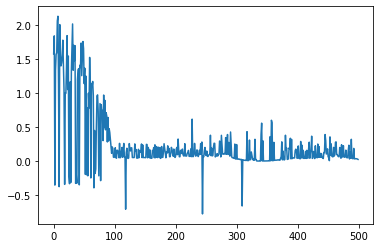

In [7]:
plt.plot(range(len(losses)), losses)

In [8]:
rewards = []
losses = []

In [9]:
dl_train, dl_dev, dl_test = load_dataset(noise=0.3)
controller = Controller()

checkpoint = torch.load(PATH)
controller.load_state_dict(checkpoint['model_state_dict'])
controller.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [10]:
print('Pre-Training controller...')

for i in range(num_rollouts):
    reward = controller.generate_rollout(dl_train, dl_dev)
    loss = controller.optimize()
    controller.beta *= 0.99

    rewards.append(reward)
    losses.append(loss)

    if i % 100 == 0 and i > 0:
        print(f'Rollout {i}, mean reward: {np.mean(rewards[-100:])}, beta: {controller.beta}, loss: {np.mean(losses[-100:])}')
    
    if best_loss>abs(loss):
        torch.save({
            'epoch': i,
            'model_state_dict': controller.state_dict(),
            'optimizer_state_dict': controller.optimizer.state_dict(),
            'loss': loss,
            }, PATH)
        
        best_loss = abs(loss)
        print(f'Model save with loss {loss} at rollout{i}')
        
with open('rewards_losses.pkl', 'wb') as handle:
    pkl.dump((rewards, losses), handle, protocol=pkl.HIGHEST_PROTOCOL)


Pre-Training controller...
Model save with loss 0.0013077621115371585 at rollout0
Model save with loss 0.0012342415284365416 at rollout1
Model save with loss 0.0009883291786536574 at rollout2
Model save with loss 0.0009436894324608147 at rollout5
Model save with loss 0.0009234615718014538 at rollout6
Model save with loss 0.000888029404450208 at rollout8
Model save with loss 0.0008577218395657837 at rollout10
Model save with loss 0.0008441354148089886 at rollout11
Model save with loss 0.0008194604306481779 at rollout13
Model save with loss 0.0008082102867774665 at rollout14
Model save with loss 0.0007975968183018267 at rollout15
Model save with loss 0.0006441958248615265 at rollout17
Model save with loss 0.000573297031223774 at rollout56
Rollout 100, mean reward: 0.348046875, beta: 0.0036237201786049693, loss: 0.00360308637318667
Model save with loss 0.00048750537098385394 at rollout104
Model save with loss 0.00048332466394640505 at rollout105
Model save with loss 0.00035641479189507663

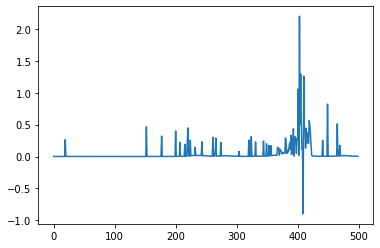

In [15]:
plt.plot(range(len(losses)), losses)